In [73]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler,PowerTransformer
from sklearn.decomposition import PCA
from sklearn.mixture import BayesianGaussianMixture,GaussianMixture
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from sklearn import metrics
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")


In [74]:
df=pd.read_csv("/kaggle/input/th-gaussion/Gia SMP va SMPcap 2021(Gi th trng SMP).csv",encoding='latin-1')


In [75]:
feats= ['6']

In [76]:
df.head()

,Ngày,1,2,3,4,5,6,7,8,9,...,39,40,41,42,43,44,45,46,47,48
0,1/1/2021,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,...,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4
1,1/2/2021,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,...,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7
2,1/3/2021,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4,...,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4
3,1/4/2021,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.1,...,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8
4,1/5/2021,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,...,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5


In [77]:
from sklearn.preprocessing import PowerTransformer

# Chuyển đổi cột '11' thành mảng 2D
X = df['6'].values.reshape(-1, 1)

# Áp dụng PowerTransformer
transformer = PowerTransformer()
X_transformed = transformer.fit_transform(X)

In [78]:
BGM = BayesianGaussianMixture(n_components=7,covariance_type='full',random_state=1,n_init=15)
# fit model and predict clusters
preds = BGM.fit_predict(X)

#Adding the Clusters feature to the orignal dataframe.
df["Clusters"]= preds

In [79]:
pp=BGM.predict_proba(X)# Calcualting the probabilities of each prediction
df_new=pd.DataFrame(X,columns=feats) 
df_new[[f'predict_proba_{i}' for i in range(7)]]=pp # creating new dataframe columns of probabilites 
df_new['preds']=preds
df_new['predict_proba']=np.max(pp,axis=1)
df_new['predict']=np.argmax(pp,axis=1)
    
train_index=np.array([])
for n in range(7):
    n_inx=df_new[(df_new.preds==n) & (df_new.predict_proba > 0.68)].index
    train_index = np.concatenate((train_index, n_inx))

In [80]:
from sklearn.model_selection import StratifiedKFold
X_new=df_new.loc[train_index][feats]
y=df_new.loc[train_index]['preds']

params_lgb = {'learning_rate': 0.06,'objective': 'multiclass','boosting': 'gbdt','n_jobs': -1,'verbosity': -1, 'num_classes':7} 

model_list=[]

gkf = StratifiedKFold(11)
for fold, (train_idx, valid_idx) in enumerate(gkf.split(X_new,y)):   

    tr_dataset = lgb.Dataset(X_new.iloc[train_idx],y.iloc[train_idx],feature_name = feats)
    vl_dataset = lgb.Dataset(X_new.iloc[valid_idx],y.iloc[valid_idx],feature_name = feats)
    
    model = lgb.train(params = params_lgb, 
                train_set = tr_dataset, 
                valid_sets =  vl_dataset, 
                num_boost_round = 5000, 
                callbacks=[ lgb.early_stopping(stopping_rounds=300, verbose=False), lgb.log_evaluation(period=200)])  
    
    model_list.append(model) 


[200]	valid_0's multi_logloss: 0.000151726
[400]	valid_0's multi_logloss: 0.000151726
[200]	valid_0's multi_logloss: 0.000153686
[400]	valid_0's multi_logloss: 0.000153686
[200]	valid_0's multi_logloss: 0.000154034
[400]	valid_0's multi_logloss: 0.000154034
[200]	valid_0's multi_logloss: 0.000156754
[400]	valid_0's multi_logloss: 0.000156754
[200]	valid_0's multi_logloss: 0.000153261
[400]	valid_0's multi_logloss: 0.000153261
[200]	valid_0's multi_logloss: 0.00015524
[400]	valid_0's multi_logloss: 0.00015524
[200]	valid_0's multi_logloss: 0.000155472
[400]	valid_0's multi_logloss: 0.000155472
[200]	valid_0's multi_logloss: 9.92419e-06
[400]	valid_0's multi_logloss: 9.8222e-06
[600]	valid_0's multi_logloss: 9.75475e-06
[800]	valid_0's multi_logloss: 9.70667e-06
[1000]	valid_0's multi_logloss: 9.67072e-06
[1200]	valid_0's multi_logloss: 9.64285e-06
[1400]	valid_0's multi_logloss: 9.62062e-06
[1600]	valid_0's multi_logloss: 9.60248e-06
[1800]	valid_0's multi_logloss: 9.5874e-06
[2000]	val

In [81]:
lgb_preds=0
for model in model_list:
    lgb_preds+=model.predict(df_new[feats])

In [82]:
labels=np.argmax(lgb_preds,axis=1)

NameError: name 'PCA_ds' is not defined

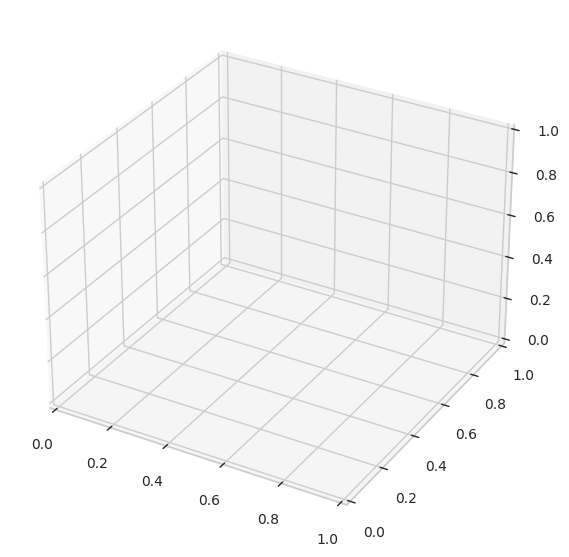

In [83]:
ss.Predicted=np.argmax(lgb_preds,axis=1)